In [22]:
from sklearn.decomposition import PCA
# from imblearn.under_sampling import RandomUnderSampler
# from imblearn.over_sampling import ADASYN
# from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SKPipeline

from sklearn.svm import SVC
from itertools import combinations

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV # GridSearchCV
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score, make_scorer # , f1_score, fbeta_score
# from scipy.stats import mode
from collections import Counter



In [2]:
stroke = pd.read_csv("../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

Creo una prima pipeline per fare imputer, scaler, undersampling e oversampling in modo da rendere i dati buoni per studi e modelli

In [4]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])

pipeline_preprocessing = SKPipeline(steps=[
  ('preprocessor', preprocessor_with_imputation),
])

# pipeline_sampling = ImbPipeline([
#   ('preprocessor', preprocessor_with_imputation),
#   ('undersampler', RandomUnderSampler(random_state=0, sampling_strategy=0.20)),
#   ('oversampler', ADASYN(n_neighbors=7, random_state=0, sampling_strategy=1)),
# ])

In [5]:
# pipeline_model = SKPipeline([
#   ('pca', PCA(random_state=0, n_components=None)),
#   # ('classifier', SVC(random_state=0, probability=True, kernel='rbf', class_weight='balanced'))
# ])

ovviamente eseguo il train test split per il futuro

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

uso la pipeline per avere dati buoni per la pca

In [7]:
X_resampled = pipeline_preprocessing.fit_transform(X_train)

In questo momento devo esplorare i risultati, quindi evito la pipeline e mi concentro sul vedere quanto spiegano le varie componenti

In [8]:
pca = PCA(random_state=0, n_components=None)
X_train_pca = pca.fit(X_resampled)
variance_ratio = X_train_pca.explained_variance_ratio_

variance_ratio

array([2.62551277e-01, 1.30798146e-01, 1.14049640e-01, 1.06799519e-01,
       8.62286557e-02, 6.44787434e-02, 6.12228077e-02, 4.26547594e-02,
       3.70569497e-02, 2.44857681e-02, 2.37994081e-02, 2.03967377e-02,
       1.78053496e-02, 7.08373991e-03, 5.41431972e-04, 4.70664798e-05,
       4.16243782e-18, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00])

uso la funzione cumsum di numpy per vedere quanto spiegano le componenti principali man mano che si accumulano

In [9]:
variance_ratio_cumulative = np.cumsum(variance_ratio)

variance_ratio_cumulative

array([0.26255128, 0.39334942, 0.50739906, 0.61419858, 0.70042724,
       0.76490598, 0.82612879, 0.86878355, 0.9058405 , 0.93032627,
       0.95412567, 0.97452241, 0.99232776, 0.9994115 , 0.99995293,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        ])

considerando le prime 12 componenti principali riusciamo a spiegare il 96% della varianza, potrebbe essere interessante questo dato considerando che mi permette di quasi dimezzare il numero di dimensioni.

Ora vado a vedere un grafico cumulativo delle dimensioni

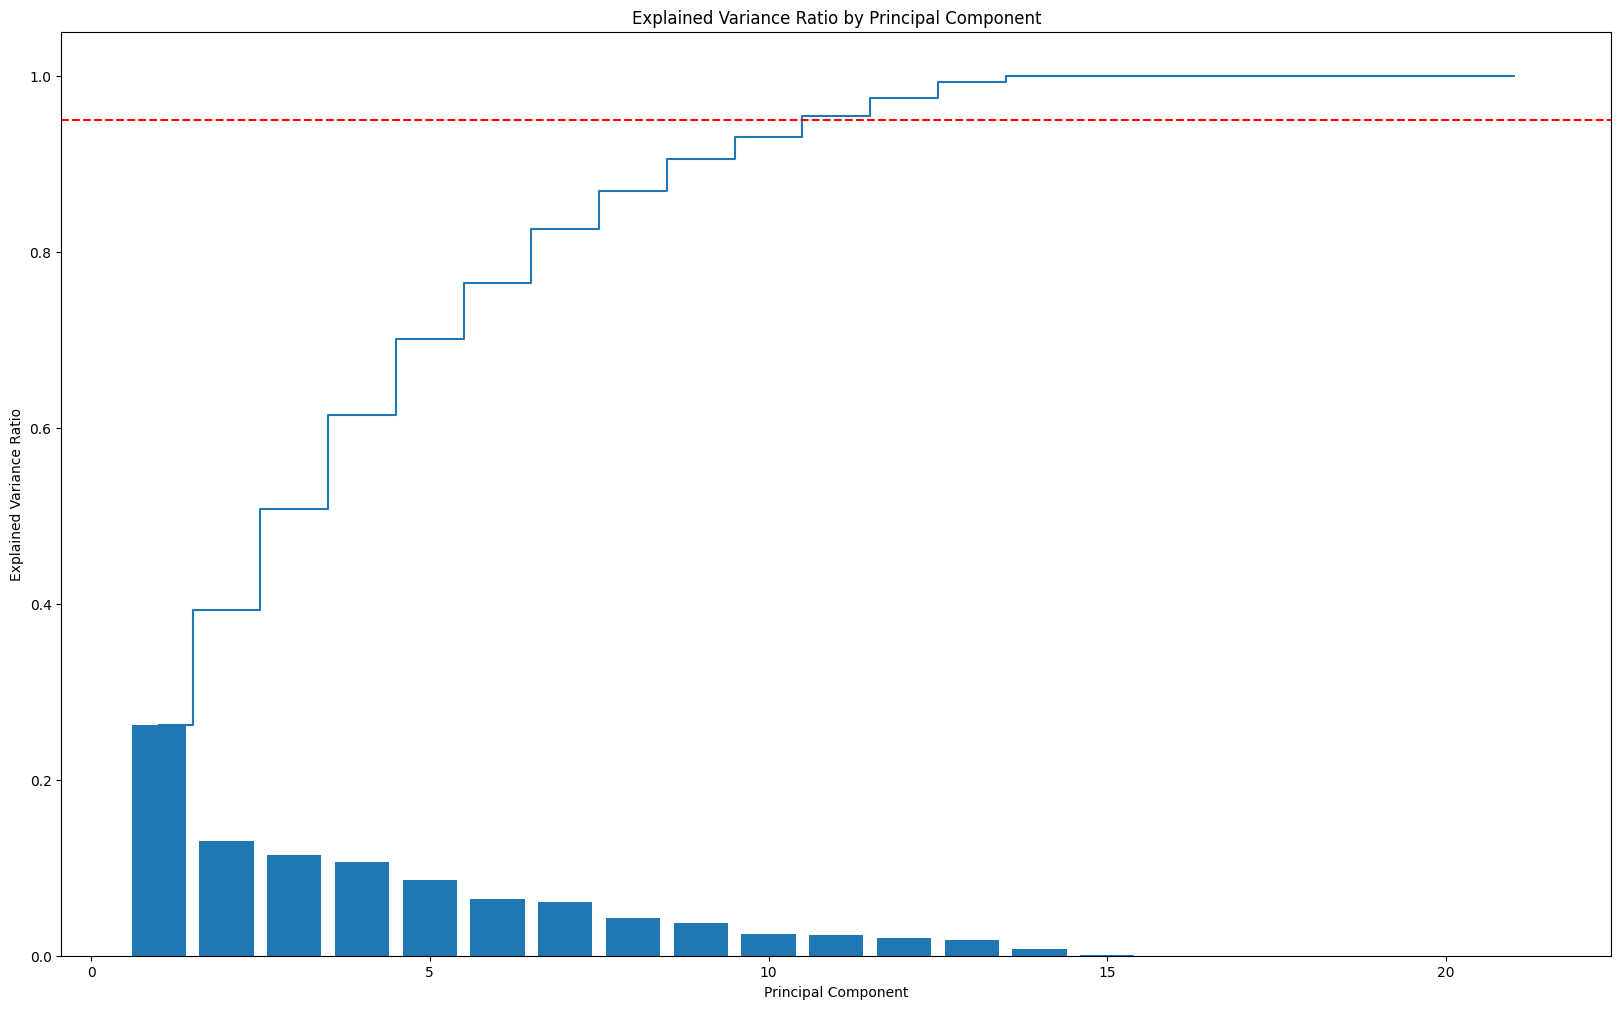

In [10]:
plt.figure(figsize=(20, 12))
plt.step(range(1, len(variance_ratio_cumulative) + 1), variance_ratio_cumulative, where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, len(variance_ratio) + 1), variance_ratio, label='Explained Variance by Component')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio by Principal Component')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')
plt.show()

vedo che con 11 dimensioni viene spiegato più del 95% della varianza.

La mia idea sarà addestrare un modello con le 2 dimensioni principali, poi quello con le 3, poi con le 4, 5 e così via fino ad 11 dimensioni.

Sottoporre i dati a un hard voting e considerare a 1 se il 30% dei voti risulta a 1

trasformo i dati

In [11]:
X_train_pca = pca.transform(X_resampled)


In [12]:
def balanced_score(y_true, y_pred, w_tp=0.6, w_tn=0.4):
    cm = confusion_matrix(y_true, y_pred)

    # cm layout:
    # [[TN, FP],
    #  [FN, TP]]
    tn, fp, fn, tp = cm.ravel()

    total_pos = tp + fn
    total_neg = tn + fp

    tpr = tp / total_pos if total_pos > 0 else 0  # Sensibilità / Recall
    tnr = tn / total_neg if total_neg > 0 else 0  # Specificità

    score = w_tp * tpr + w_tn * tnr
    return score

In [25]:
def find_best_combination(X_train_pca, y_resampled, X_cv_test, y_cv_test, n_components):
    class ColumnSelector(BaseEstimator, TransformerMixin):
        def __init__(self, columns):
            self.columns = columns
        def fit(self, X, y=None):
            return self
        def transform(self, X):
            return X[:, self.columns]

    combs = list(combinations(range(11), n_components))

    best_score = 0
    best_model = None
    best_combination = None

    custom_scorer = make_scorer(balanced_score, w_tp=0.5, w_tn=0.5, greater_is_better=True)

    for comb in combs:
        # print(comb)
        pipeline = SKPipeline([
            ('selector', ColumnSelector(comb)),
            #   ('undersampler', RandomUnderSampler(random_state=0, sampling_strategy=0.20)),
            #   ('oversampler', ADASYN(n_neighbors=7, random_state=0, sampling_strategy=1)),
            ('svm', SVC(kernel='linear', random_state=0, class_weight='balanced'))
            # class_weight='balanced'
        ])
        param_grid = {
            "svm__C": [0.1, 1, 10, 100],
            "svm__kernel": ['linear', 'rbf', 'poly'],
            # "svm__gamma": ['scale', 'auto']
        }
        gs = RandomizedSearchCV(pipeline, param_distributions=param_grid, cv=5, scoring=custom_scorer, n_jobs=-1, random_state=0, n_iter=5)
        
        gs.fit(X_train_pca, y_resampled)
        # pipeline.fit(X_train_pca, y_resampled)
        # preds = pipeline.predict(X_cv_test)
        # custom_scorer = make_scorer(balanced_score, greater_is_better=True)
        # score = balanced_score(y_cv_test, preds, 0.5, 0.5)
        print(f"cur_score: {gs.best_score_} for combination: {comb}")
        if gs.best_score_ > best_score:
            best_score = gs.best_score_
            best_model = gs.best_estimator_
            best_combination = comb

    return best_combination, best_score, best_model

In [26]:
models = []


for i in [2,6,11]:
  X_secondary_split_train, X_secondary_split_test, y_secondary_split_train, y_secondary_split_test = train_test_split(X_train_pca, y_train, test_size=0.3, random_state=i)
  print(f"Testing combinations of {i} components")
  models.append(find_best_combination(X_secondary_split_train, y_secondary_split_train, X_secondary_split_test, y_secondary_split_test, i))

Testing combinations of 2 components
cur_score: 0.7326730551593441 for combination: (0, 1)
cur_score: 0.7202134854785678 for combination: (0, 2)
cur_score: 0.7403623494117095 for combination: (0, 3)
cur_score: 0.7605001640650636 for combination: (0, 4)
cur_score: 0.7059401597792823 for combination: (0, 5)
cur_score: 0.7202231954517148 for combination: (0, 6)
cur_score: 0.7154636344764315 for combination: (0, 7)
cur_score: 0.7330393555256445 for combination: (0, 8)
cur_score: 0.747127187255158 for combination: (0, 9)
cur_score: 0.7145505621739625 for combination: (0, 10)
cur_score: 0.6647079307042744 for combination: (1, 2)
cur_score: 0.6313782804642037 for combination: (1, 3)
cur_score: 0.7057416075697611 for combination: (1, 4)
cur_score: 0.5705208563526663 for combination: (1, 5)
cur_score: 0.6474988448480221 for combination: (1, 6)
cur_score: 0.6277340270941734 for combination: (1, 7)
cur_score: 0.6127009797028078 for combination: (1, 8)
cur_score: 0.6400037500585947 for combination

In [27]:
models

[((0, 4),
  np.float64(0.7605001640650636),
  Pipeline(steps=[('selector', ColumnSelector(columns=(0, 4))),
                  ('svm',
                   SVC(C=10, class_weight='balanced', kernel='linear',
                       random_state=0))])),
 ((0, 3, 4, 6, 8, 9),
  np.float64(0.7777573530784541),
  Pipeline(steps=[('selector', ColumnSelector(columns=(0, 3, 4, 6, 8, 9))),
                  ('svm',
                   SVC(C=10, class_weight='balanced', kernel='linear',
                       random_state=0))])),
 ((0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10),
  np.float64(0.7582693533580608),
  Pipeline(steps=[('selector',
                   ColumnSelector(columns=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10))),
                  ('svm',
                   SVC(C=10, class_weight='balanced', kernel='linear',
                       random_state=0))]))]

In [28]:
# import numpy as np
# from collections import Counter

def hard_voting_predict(models, X_pca, perc_class_0=0.40):
    all_preds = []

    for _, _, pipeline in models:
        preds = pipeline.predict(X_pca)
        all_preds.append(preds)

    all_preds = np.array(all_preds)
    num_models = len(models)

    final_preds = []
    for i in range(all_preds.shape[1]):
        votes = Counter(all_preds[:, i])
        
        # Conteggia i voti per la classe 0 (Nessun ictus)
        votes_class_0 = votes.get(0, 0)
        
        # Calcola la percentuale di voti per la classe 0
        percentage_class_0 = votes_class_0 / num_models

        # Applica la nuova logica: se almeno il 40% dei modelli vota per la classe 0, la predizione finale è 0
        if percentage_class_0 >= perc_class_0:
            final_preds.append(0)
        else:
            # Altrimenti, la predizione finale è 1
            final_preds.append(1)

    return np.array(final_preds)

In [29]:
X_train_pca

array([[-1.83539455e-02, -1.19459051e+00, -6.38999725e-01, ...,
         5.55111512e-17,  0.00000000e+00,  0.00000000e+00],
       [ 6.83862011e-01, -1.85819900e+00, -4.48684371e-01, ...,
         1.66533454e-16,  0.00000000e+00,  2.22044605e-16],
       [ 2.72681370e-01, -7.67700620e-01, -8.78154967e-01, ...,
         2.22044605e-16,  0.00000000e+00,  1.11022302e-16],
       ...,
       [-6.50336267e-02, -2.76022801e-01, -3.30212285e-01, ...,
         2.77555756e-16,  2.22044605e-16, -1.11022302e-16],
       [-7.89266393e-01,  1.40563120e-01,  5.02983809e-01, ...,
        -1.66533454e-16, -4.44089210e-16, -1.11022302e-16],
       [ 1.45722680e+00, -7.84631164e-01,  1.11875919e+00, ...,
        -2.10942375e-15, -3.10862447e-15, -1.38777878e-15]],
      shape=(4088, 21))

In [30]:
def evaluate_predictions(predictions, y_true):
    # majority_vote = (np.stack(predictions).mean(axis=0) >= 0.2).astype(int)
    cm = confusion_matrix(y_true, predictions)
    class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    perc_true_negative = cm[0,0]*100/(cm[0,0]+cm[0,1])
    perc_true_positive = cm[1,1]*100/(cm[1,0]+cm[1,1])
    
    print(f"Percentuale di veri negativi: {perc_true_negative:.2f}%")
    print(f"Percentuale di veri positivi: {perc_true_positive:.2f}%")
    
    print(classification_report(y_true, predictions, target_names=class_names))
    print(cm)
    
    fpr, tpr, thresholds = roc_curve(y_true, predictions)
    auc = roc_auc_score(y_true, predictions)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='lower right')
    plt.show()

In [31]:
X_preprocessed_train = pipeline_preprocessing.fit_transform(X_train)

In [32]:
X_preprocessed_train

array([[-0.32824306, -0.33206349, -0.23963241, ...,  1.        ,
         0.        ,  0.        ],
       [-0.41649391, -0.33206349, -0.23963241, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.73076708, -0.33206349, -0.23963241, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [ 0.02476032, -0.33206349, -0.23963241, ...,  0.        ,
         0.        ,  1.        ],
       [-0.9901244 , -0.33206349, -0.23963241, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.64251624,  3.01147232, -0.23963241, ...,  0.        ,
         1.        ,  0.        ]], shape=(4088, 21))

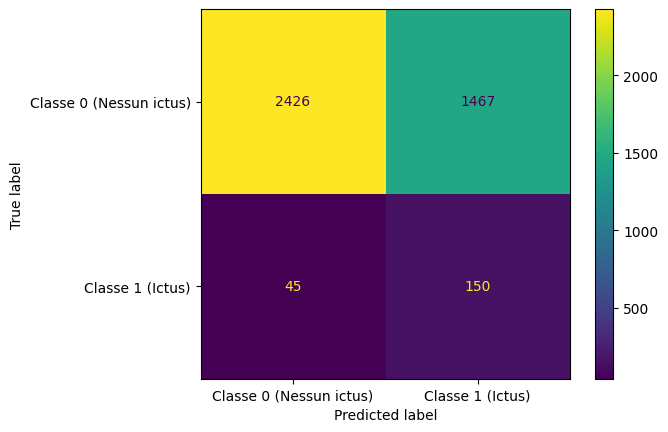

Percentuale di veri negativi: 62.32%
Percentuale di veri positivi: 76.92%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.98      0.62      0.76      3893
       Classe 1 (Ictus)       0.09      0.77      0.17       195

               accuracy                           0.63      4088
              macro avg       0.54      0.70      0.46      4088
           weighted avg       0.94      0.63      0.73      4088

[[2426 1467]
 [  45  150]]


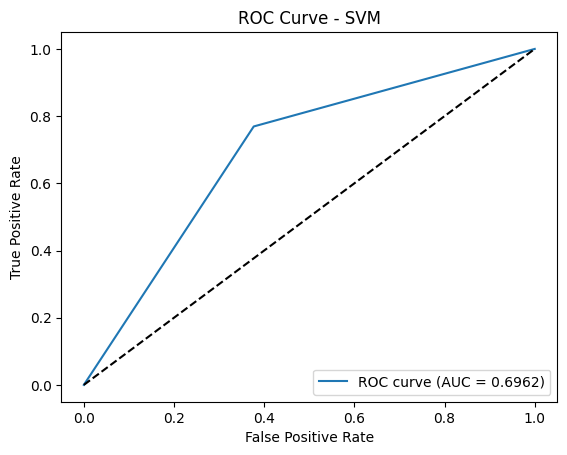

In [38]:
hard_voting_train = hard_voting_predict(models, X_preprocessed_train, perc_class_0=0.5)

evaluate_predictions(hard_voting_train, y_train)

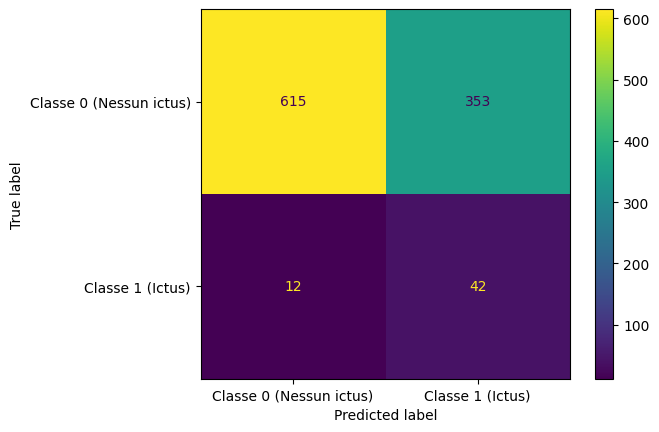

Percentuale di veri negativi: 63.53%
Percentuale di veri positivi: 77.78%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.98      0.64      0.77       968
       Classe 1 (Ictus)       0.11      0.78      0.19        54

               accuracy                           0.64      1022
              macro avg       0.54      0.71      0.48      1022
           weighted avg       0.93      0.64      0.74      1022

[[615 353]
 [ 12  42]]


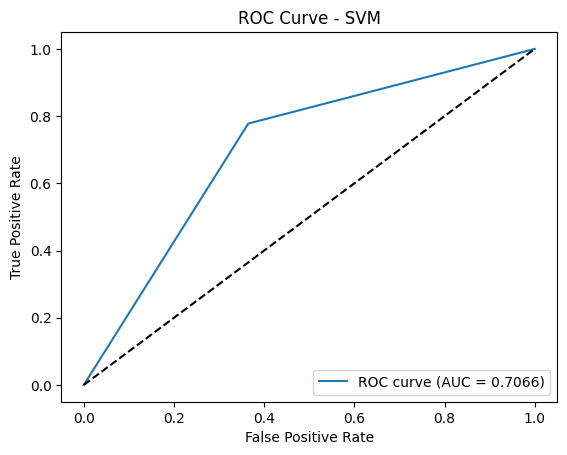

In [37]:
X_preprocessed_test = pipeline_preprocessing.transform(X_test)

hard_voting_test = hard_voting_predict(models, X_preprocessed_test, 0.5)

evaluate_predictions(hard_voting_test, y_test)